# MIKH Model: Startup Shear (Stress Overshoot)

> **Handbook:** See [MIKH Reference](../../docs/source/models/ikh/mikh.rst) for startup physics, return mapping formulation, kinematic hardening parameters, and industrial startup applications.

## Protocol Context: Startup Shear for IKH Models

**Startup shear** applies a sudden constant shear rate $\dot{\gamma}_0$ to an initially structured material. The **stress overshoot** phenomenon reveals the interplay of elastic loading, kinematic hardening (backstress $\alpha$ evolution), and structure breakdown ($\lambda$ decreases during flow).

**Key Mechanisms**:
- **Initial elastic loading**: $\sigma \approx G\gamma = G\dot{\gamma}\_0 t$ (linear increase)
- **Yield onset**: When $|\sigma - \alpha| > \sigma_y(\lambda)$, plastic flow begins
- **Overshoot peak**: Backstress $\alpha$ develops (Armstrong-Frederick kinematic hardening) while structure $\lambda$ breaks down
- **Steady-state approach**: Balance between aging and rejuvenation

**Physical Signature**: The overshoot is a hallmark of thixotropic yield-stress fluids — purely viscoplastic materials (no thixotropy or kinematic hardening) do NOT show overshoots.

> **Further Reading**: See [MIKH Handbook](../../docs/source/models/ikh/mikh.rst) for startup physics, return mapping formulation, and kinematic hardening parameters ($C$, $\gamma_{dyn}$, $m$).

## Learning Objectives

1. Fit the **MIKH** model to startup shear data with **stress overshoot**
2. Understand the interplay of **kinematic hardening** and **thixotropy** in transient response
3. Analyze rate-dependent overshoot peak magnitude and timing
4. Use return mapping formulation for strain-driven protocols
5. Apply Bayesian inference to quantify parameter uncertainty

## Prerequisites

- NB01: MIKH Flow Curve (calibrates base parameters)

**Estimated Time:** 3-4 minutes (fast demo), 12-15 minutes (full run)

## Estimated Runtime

- **Fast demo**: ~3-4 minutes
- **Full run**: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    compute_fit_quality,
    get_mikh_param_names,
    load_pnas_startup,
    print_convergence_summary,
    print_parameter_comparison,
    save_ikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc

gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


81

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|--------|
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

For IKH models, watch for correlations between yield stress and hardening parameters in the pair plot.

## 2. Theory: Startup Shear Response

When a constant shear rate $\dot{\gamma}$ is suddenly applied to a thixotropic yield-stress fluid, the stress response typically shows:

### Stress Overshoot Mechanism

1. **Initial elastic response**: $\sigma \approx G \gamma = G \dot{\gamma} t$ (linear increase)
2. **Yield and plasticity onset**: When $|\sigma - \alpha| > \sigma_y$, plastic flow begins
3. **Overshoot peak**: Competition between hardening and structure breakdown
4. **Steady state**: Balance of aging and rejuvenation

### Key Equations

**Return mapping algorithm** (incremental stress update):
$$
\sigma^{trial} = \sigma^n + G \Delta\gamma
$$
$$
\sigma^{n+1} = \sigma^{trial} - G \Delta\gamma^p \cdot \text{sign}(\sigma^{trial} - \alpha)
$$

**Kinematic hardening** (backstress evolution):
$$
\alpha^{n+1} = \alpha^n + C \Delta\gamma_p - \gamma_{dyn} |\alpha|^{m-1} \alpha |\Delta\gamma_p|
$$

**Structure evolution** (at each time step):
$$
\lambda^{n+1} = \lambda^n + \left[\frac{1-\lambda^n}{\tau_{thix}} - \Gamma \lambda^n |\dot{\gamma}^p|\right] \Delta t
$$

### Overshoot Physics

- **Kinematic hardening** ($C$, $\gamma_{dyn}$): Shifts yield surface, creates backstress
- **Structure breakdown** ($\Gamma$, $\tau_{thix}$): Reduces yield stress during flow
- **Peak position**: Scales with $1/\dot{\gamma}$ (strain-controlled)
- **Peak magnitude**: Increases with $\dot{\gamma}$ (rate-dependent)

## 3. Load Data

We load startup shear data from the PNAS Digital Rheometer Twin dataset.

In [3]:
# Load startup data at different shear rates
rates = [0.056, 0.32, 1.0, 56.2, 100.0]
datasets = {}

for rate in rates:
    t, stress = load_pnas_startup(gamma_dot=rate)
    datasets[rate] = {"time": t, "stress": stress}
    print(f"gamma_dot = {rate:6.3f} 1/s: {len(t)} points, t_max = {t.max():.1f} s")

gamma_dot =  0.056 1/s: 500 points, t_max = 1000.0 s


gamma_dot =  0.320 1/s: 500 points, t_max = 1000.0 s


gamma_dot =  1.000 1/s: 500 points, t_max = 600.0 s


gamma_dot = 56.200 1/s: 500 points, t_max = 300.0 s


gamma_dot = 100.000 1/s: 500 points, t_max = 300.0 s


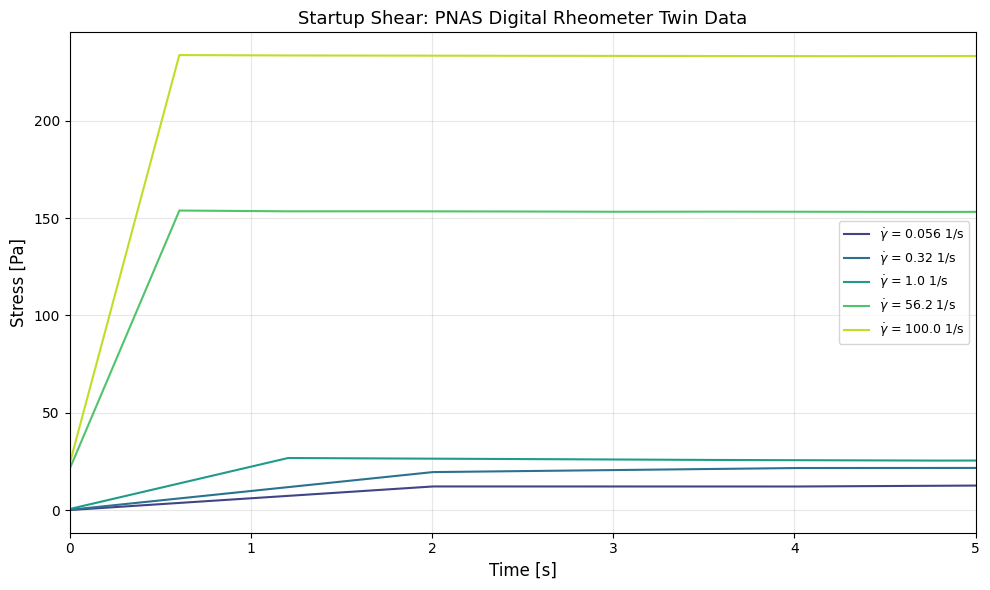

In [4]:
# Plot all startup curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(rates)))

for i, rate in enumerate(rates):
    d = datasets[rate]
    ax.plot(d["time"], d["stress"], "-", color=colors[i], lw=1.5, 
            label=f"$\\dot{{\\gamma}}$ = {rate} 1/s")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Startup Shear: PNAS Digital Rheometer Twin Data", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 5)  # Focus on overshoot region
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Fit at Single Rate (gamma_dot = 1 1/s)

In [5]:
# Select reference rate for primary fitting
ref_rate = 1.0
t_data = datasets[ref_rate]["time"]
stress_data = datasets[ref_rate]["stress"]

# Create and fit MIKH model
model = MIKH()
param_names = get_mikh_param_names()

t0 = time.time()
model.fit(t_data, stress_data, test_mode="startup", gamma_dot=ref_rate, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/mikh.py", line 460, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.11 s

Fitted parameters:
  G               = 283.1
  eta             = 2e+06
  C               = 499.6
  gamma_dyn       = 1.846
  m               = 1
  sigma_y0        = 9.99
  delta_sigma_y   = 49.93
  tau_thix        = 156.1
  Gamma           = 3.506
  eta_inf         = 0.09986
  mu_p            = 0.001


In [6]:
# Compute fit quality
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=ref_rate)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

# Residual analysis
residuals = stress_data - stress_pred
print(f"\nResidual Analysis:")
print(f"  Mean residual:  {np.mean(residuals):.4g} Pa (should be ~ 0)")
print(f"  Max abs residual: {np.max(np.abs(residuals)):.4g} Pa")


Fit Quality:
  R^2:   -48156.768730
  RMSE:  244 Pa

Residual Analysis:
  Mean residual:  -237.7 Pa (should be ~ 0)
  Max abs residual: 308.4 Pa


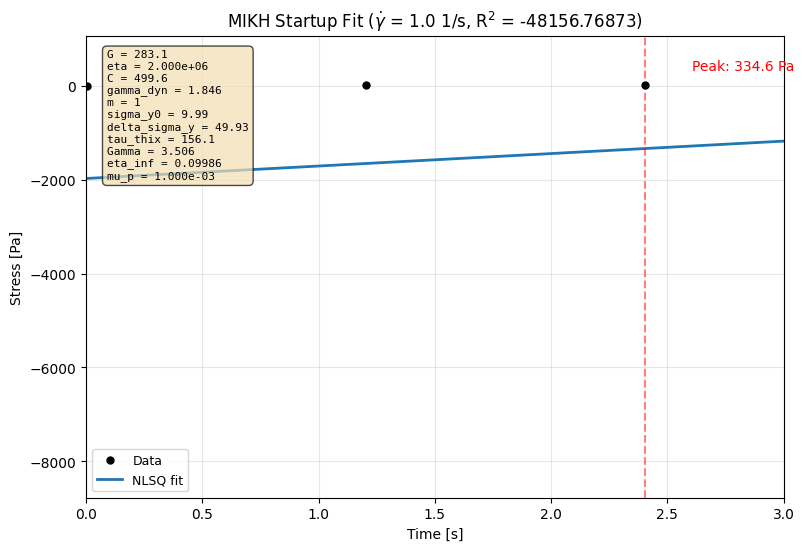

In [7]:
# Plot NLSQ fit with uncertainty band (startup: linear scale)
fig, ax = plot_nlsq_fit(
    t_data, stress_data, model, test_mode="startup",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"MIKH Startup Fit ($\\dot{{\\gamma}}$ = {ref_rate} 1/s, R$^2$ = {metrics['R2']:.5f})",
    gamma_dot=ref_rate,
)

# Mark overshoot peak
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=ref_rate)
peak_idx = np.argmax(stress_pred)
ax.axvline(t_data[peak_idx], color="red", linestyle="--", alpha=0.5)
ax.annotate(f"Peak: {float(stress_pred[peak_idx]):.1f} Pa",
            xy=(t_data[peak_idx], stress_pred[peak_idx]),
            xytext=(t_data[peak_idx] + 0.2, stress_pred[peak_idx] + 2),
            fontsize=10, color="red")
ax.set_xlim(0, min(t_data.max(), 3))

display(fig)
plt.close(fig)

### 4.2 Rate-Dependent Analysis

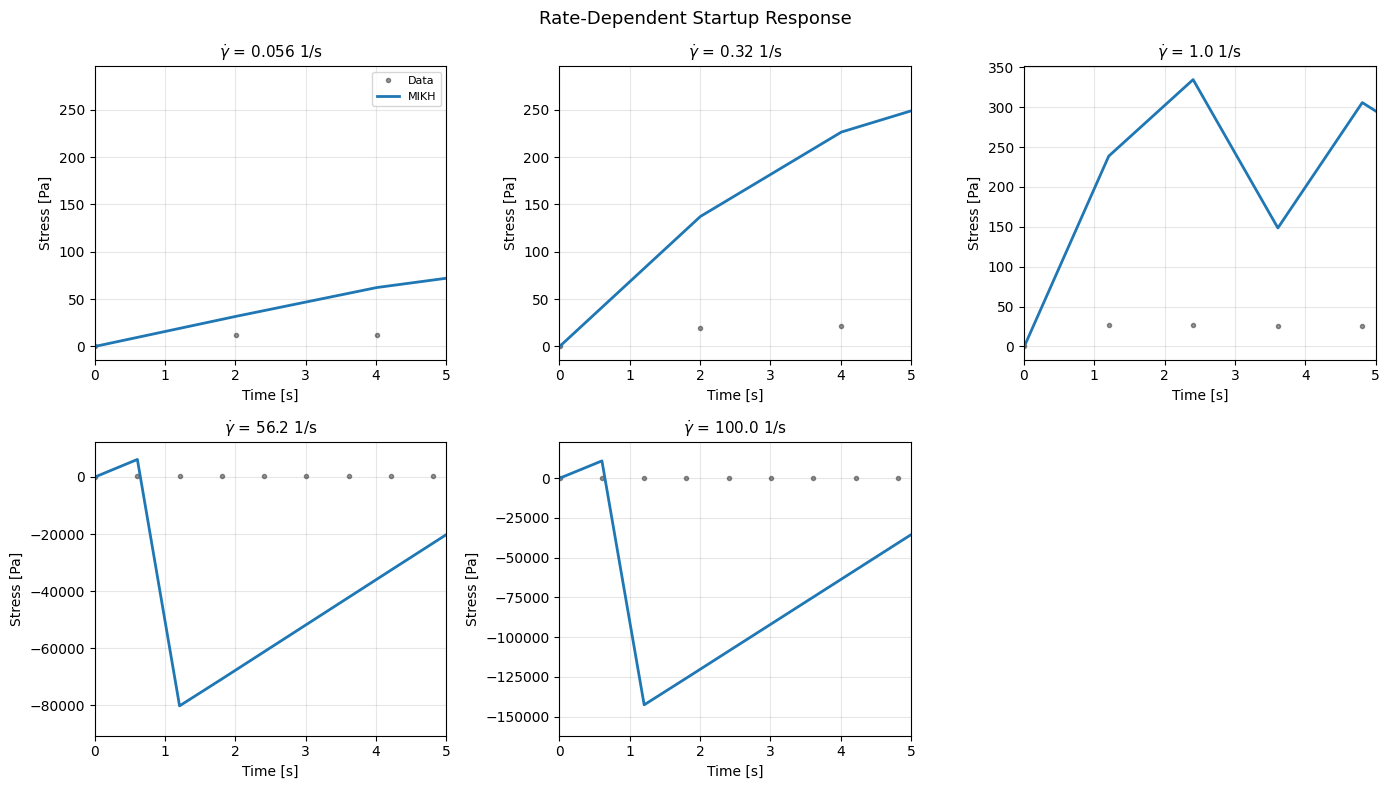

In [8]:
# Predict startup at all rates with calibrated model
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, rate in enumerate(rates[:5]):
    ax = axes[i]
    d = datasets[rate]
    t = d["time"]
    stress = d["stress"]
    
    # Model prediction at this rate
    stress_pred = model.predict(t, test_mode="startup", gamma_dot=rate)
    
    ax.plot(t, stress, "ko", markersize=3, alpha=0.4, label="Data")
    ax.plot(t, stress_pred, "-", lw=2, color="C0", label="MIKH")
    
    ax.set_xlabel("Time [s]", fontsize=10)
    ax.set_ylabel("Stress [Pa]", fontsize=10)
    ax.set_title(f"$\\dot{{\\gamma}}$ = {rate} 1/s", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, min(5, t.max()))
    if i == 0:
        ax.legend(fontsize=8)

# Remove empty subplot
axes[-1].axis("off")

plt.suptitle("Rate-Dependent Startup Response", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

In [9]:
# Bayesian inference with NLSQ warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# Fast demo config
# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="startup",
    gamma_dot=ref_rate,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:02,  1.22s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  17%|█▋        | 25/150 [00:01<00:04, 25.39it/s, 25 steps of size 5.52e-09. acc. prob=0.60]

warmup:  30%|███       | 45/150 [00:01<00:02, 47.13it/s, 24 steps of size 5.06e-09. acc. prob=0.71]

sample:  40%|████      | 60/150 [00:01<00:01, 51.73it/s, 31 steps of size 1.34e-07. acc. prob=1.00]

sample:  48%|████▊     | 72/150 [00:01<00:01, 61.19it/s, 3 steps of size 1.34e-07. acc. prob=1.00] 

sample:  56%|█████▌    | 84/150 [00:01<00:00, 69.28it/s, 15 steps of size 1.34e-07. acc. prob=1.00]

sample:  66%|██████▌   | 99/150 [00:02<00:00, 83.83it/s, 7 steps of size 1.34e-07. acc. prob=1.00] 

sample:  74%|███████▍  | 111/150 [00:02<00:00, 58.77it/s, 31 steps of size 1.34e-07. acc. prob=1.00]

sample:  81%|████████  | 121/150 [00:02<00:00, 63.87it/s, 31 steps of size 1.34e-07. acc. prob=1.00]

sample:  89%|████████▉ | 134/150 [00:02<00:00, 71.98it/s, 31 steps of size 1.34e-07. acc. prob=1.00]

sample:  96%|█████████▌| 144/150 [00:02<00:00, 59.67it/s, 3 steps of size 1.34e-07. acc. prob=1.00] 

sample: 100%|██████████| 150/150 [00:02<00:00, 50.70it/s, 3 steps of size 1.34e-07. acc. prob=1.00]


Bayesian inference time: 5.3 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

print("\n**Diagnostic Interpretation:**")
print("| Metric | Target | Meaning |")
print("|--------|--------|---------|")
print("| **R-hat** | < 1.01 | Chain convergence (1.0 = perfect) |")
print("| **ESS (bulk)** | > 400 | Effective independent samples |")
print("| **Divergences** | < 1% | NUTS geometric issues |")

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    6.6910         3     CHECK
            eta    1.0159        12     CHECK
              C    6.7438         3     CHECK
      gamma_dyn    6.7278         3     CHECK
              m    6.7297         3     CHECK
       sigma_y0    6.7675         3     CHECK
  delta_sigma_y    6.4801         3     CHECK
       tau_thix    5.2739         3     CHECK
          Gamma    6.5773         3     CHECK
        eta_inf    4.7410         3     CHECK
           mu_p    5.2629         3     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

**Diagnostic Interpretation:**
| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat** | < 1.01 | Chain convergence (1.0 = perfect) |
| **ESS (bulk)** | > 400 | Effective independent samples |
| **Divergences** | < 1% | NUTS geometric issues |


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


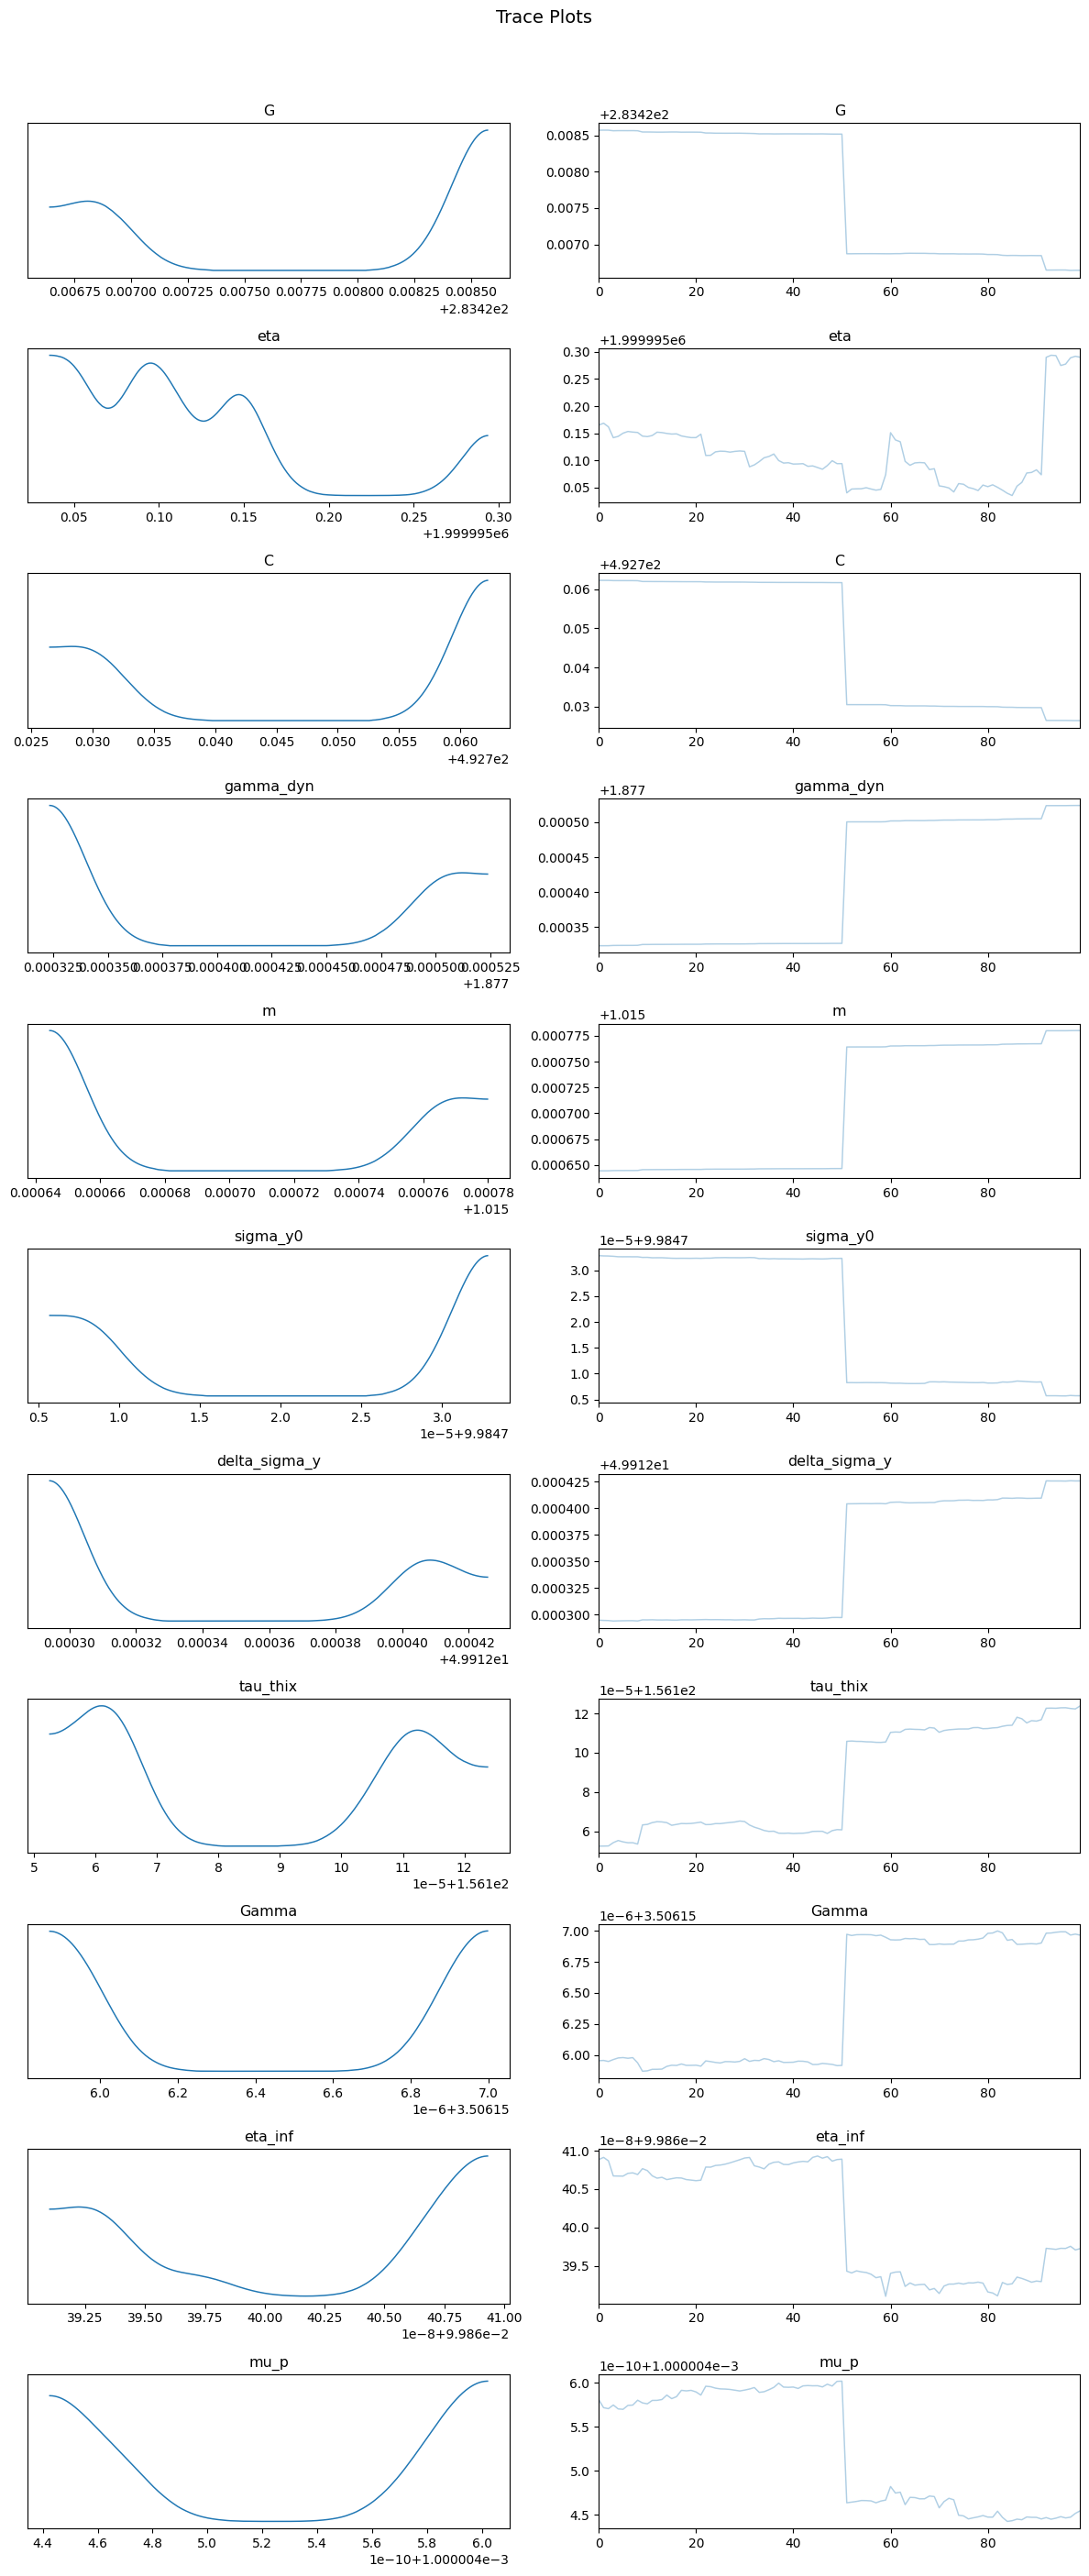

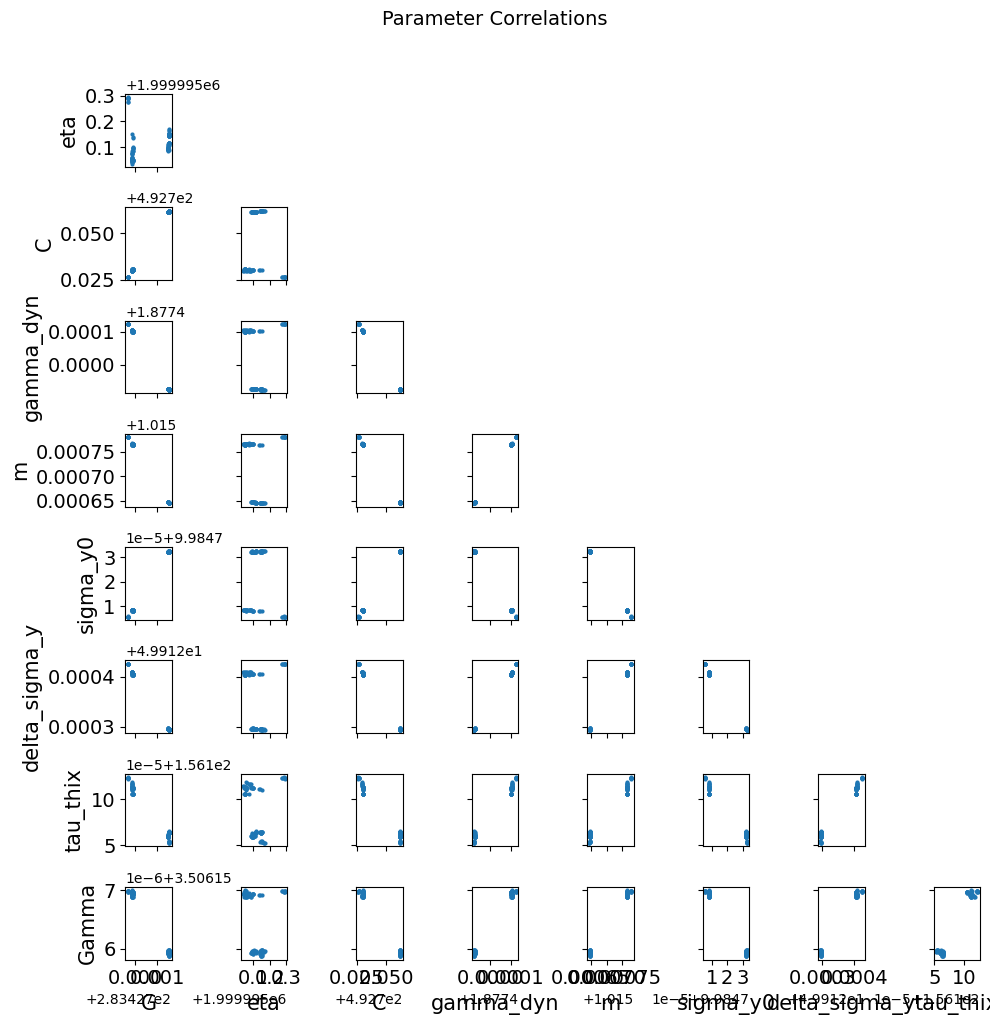

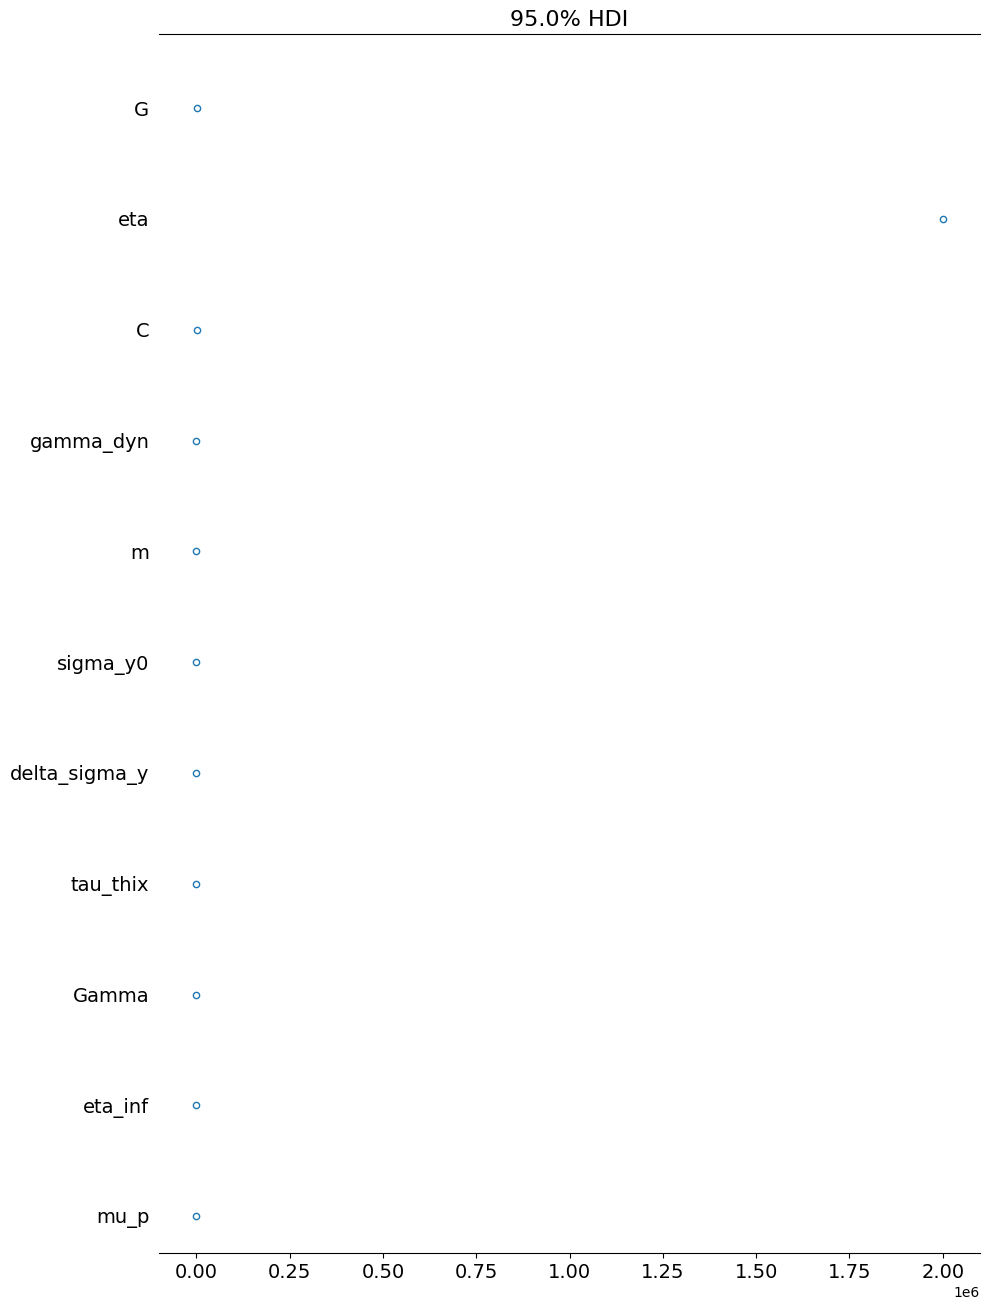

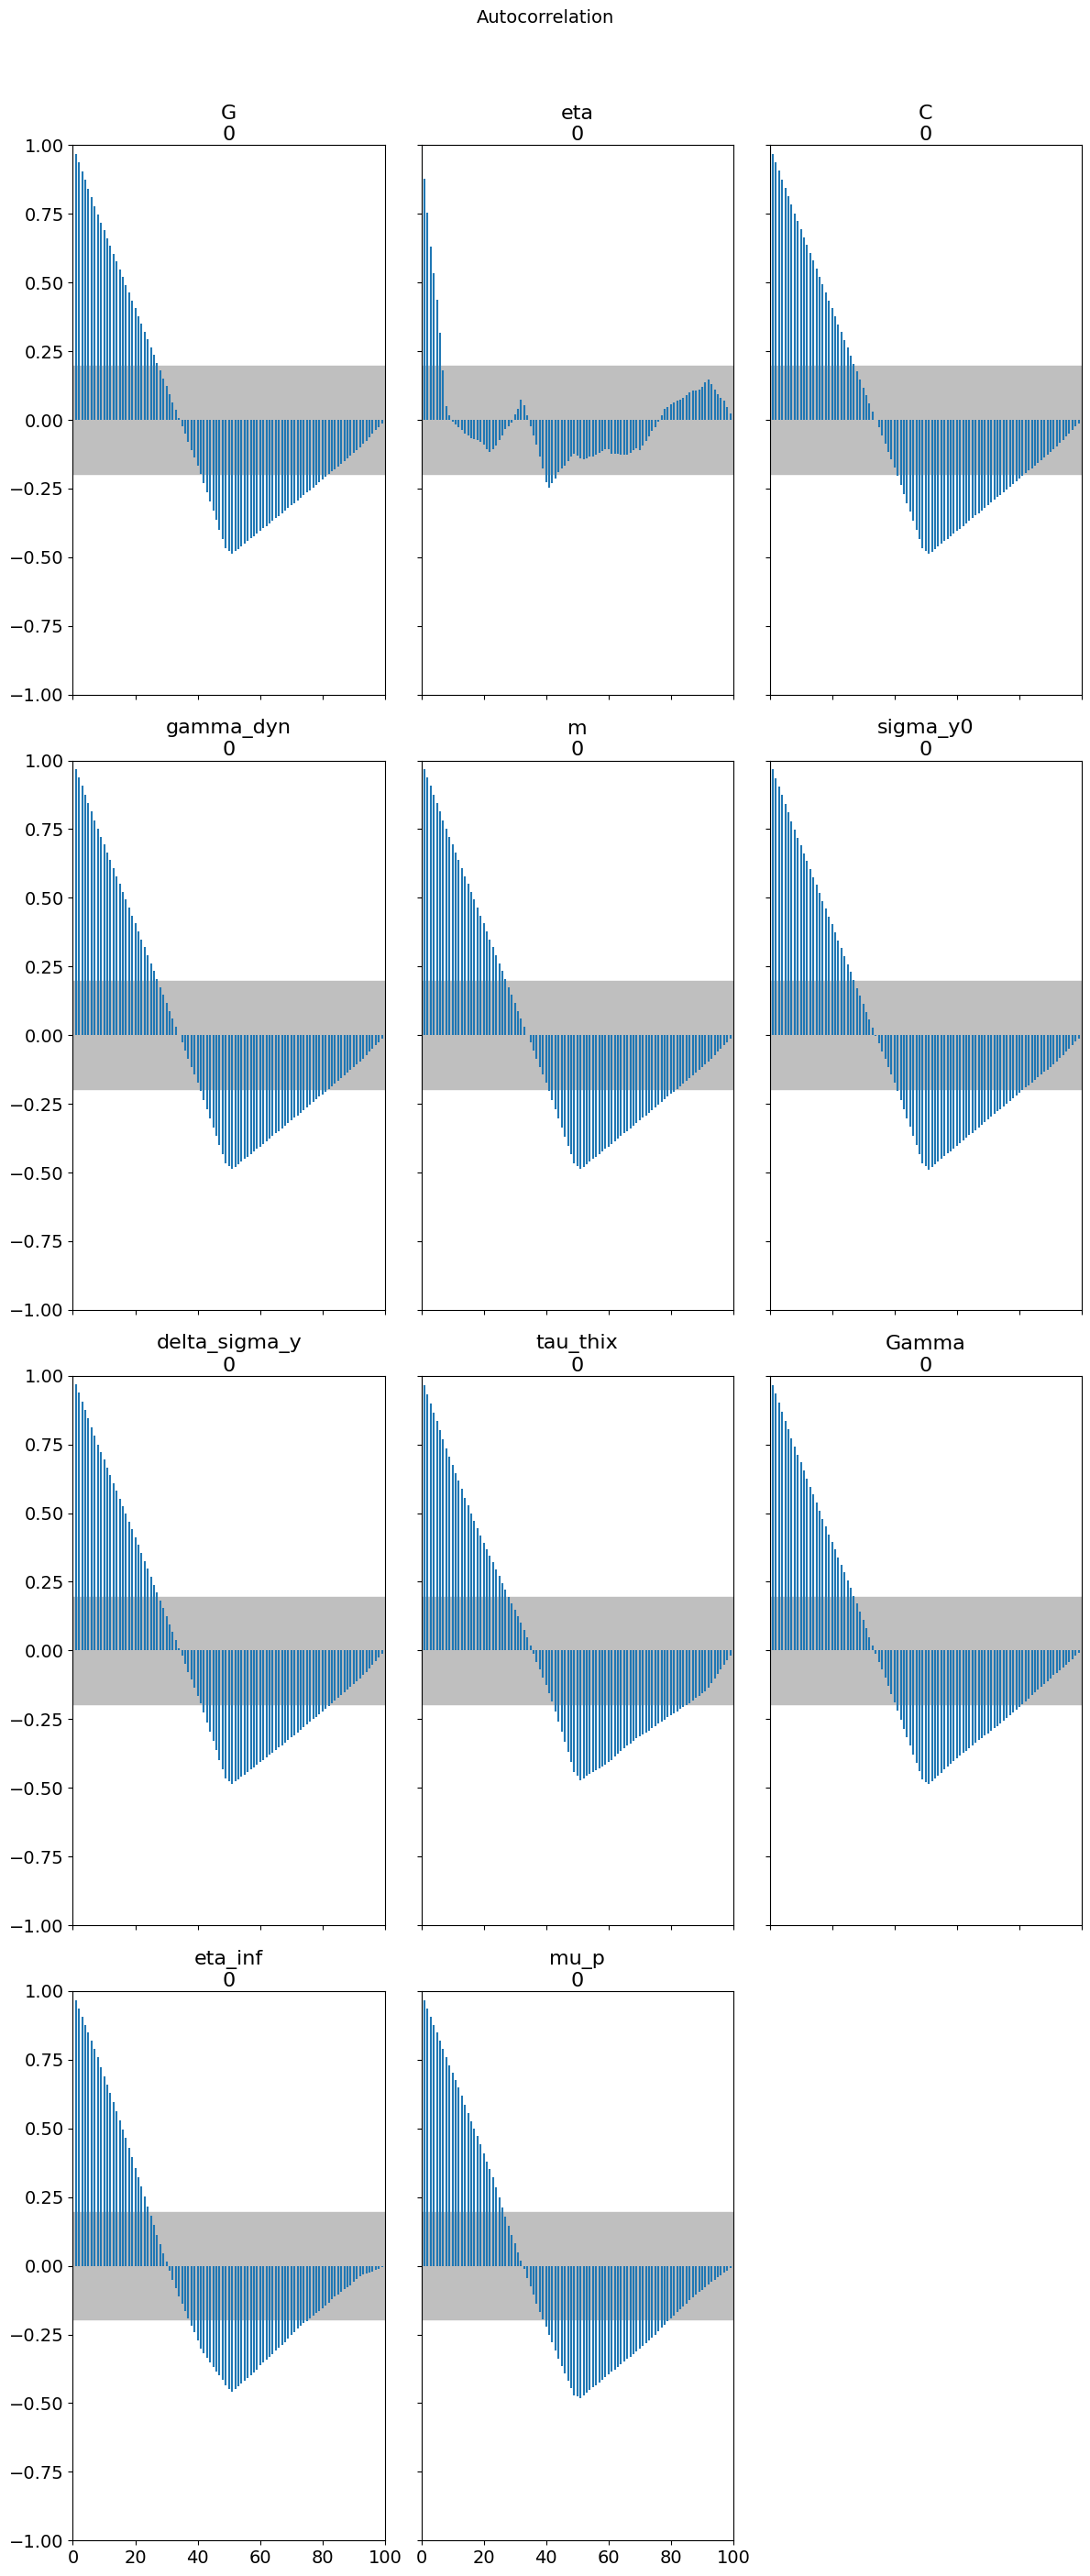

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

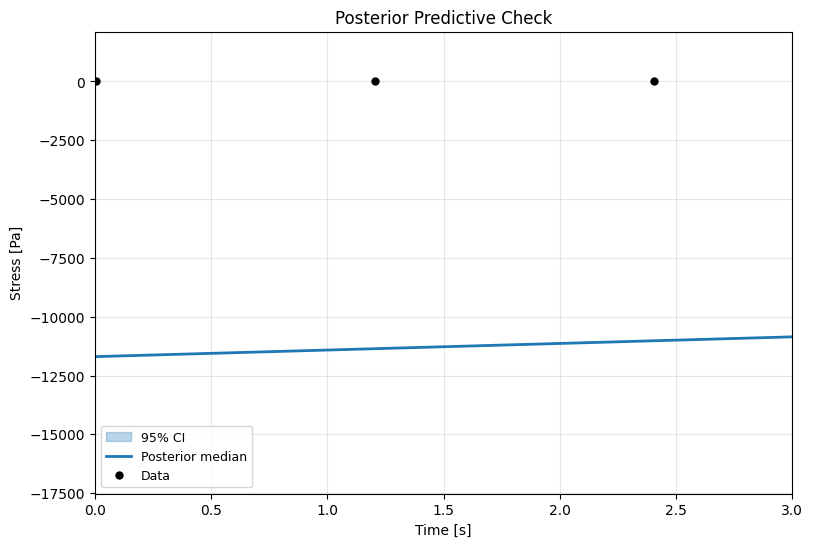

In [12]:
# Posterior predictive check
fig, ax = plot_posterior_predictive(
    t_data, stress_data, model, result,
    test_mode="startup", param_names=param_names,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    log_scale=False, gamma_dot=ref_rate,
)
ax.set_xlim(0, min(t_data.max(), 3))
display(fig)
plt.close(fig)

In [13]:
# NLSQ vs Bayesian comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         283.4         283.4  [283.4, 283.4]
            eta         2e+06         2e+06  [2e+06, 2e+06]
              C         492.7         492.8  [492.7, 492.8]
      gamma_dyn         1.878         1.877  [1.877, 1.878]
              m         1.016         1.016  [1.016, 1.016]
       sigma_y0         9.985         9.985  [9.985, 9.985]
  delta_sigma_y         49.91         49.91  [49.91, 49.91]
       tau_thix         156.1         156.1  [156.1, 156.1]
          Gamma         3.506         3.506  [3.506, 3.506]
        eta_inf       0.09986       0.09986  [0.09986, 0.09986]
           mu_p         0.001         0.001  [0.001, 0.001]


## 6. Physical Interpretation

### Stress Overshoot Mechanism

The overshoot arises from two competing mechanisms:

1. **Initial elastic loading**: Stress increases as $\sigma \approx G \dot{\gamma} t$
2. **Plastic yielding + structure breakdown**: Once yielded, stress decreases as:
   - Backstress $\alpha$ develops (kinematic hardening)
   - Structure $\lambda$ decreases (thixotropy)

### Rate Dependence

- **Peak strain** ($\gamma_{peak}$): Approximately constant (strain-controlled overshoot)
- **Peak stress** ($\sigma_{peak}$): Increases with $\dot{\gamma}$ (rate sensitivity)
- **Peak time** ($t_{peak}$): Scales as $\gamma_{peak}/\dot{\gamma}$

## 7. Save Results

In [14]:
# Save results
save_ikh_results(model, result, "mikh", "startup", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/startup/
  nlsq_params_startup.json: 11 parameters
  posterior_startup.json: 100 draws


## Key Takeaways

1. **Stress overshoot** in startup shear results from initial elastic loading followed by plastic flow and structure breakdown

2. **Kinematic hardening parameters** ($C$, $\gamma_{dyn}$) control the backstress evolution and overshoot shape

3. **Thixotropic parameters** ($\tau_{thix}$, $\Gamma$) determine how quickly structure breaks down during flow

4. **Rate dependence**: Higher $\dot{\gamma}$ leads to larger overshoot peak but shorter peak time

5. **Return mapping formulation** handles strain-driven protocols efficiently

## Next Steps

- **NB03**: Stress relaxation (synthetic from NB01 calibration)
- **NB04**: Creep response (real ML-IKH data)
- **NB05**: SAOS (synthetic from NB01 calibration)
- **NB06**: LAOS (real PNAS data)

## Further Reading

**Startup Shear Physics:**
- [MIKH Reference](../../docs/source/models/ikh/mikh.rst) — Return mapping algorithm, kinematic hardening details, industrial startup applications (pipeline restart, bearing lubrication)

**Key References:**
1. Dimitriou & McKinley (2014). *Soft Matter*, 10, 6619-6644. — Original MIKH model with startup validation
2. Armstrong & Frederick (1966). *CEGB Report RD/B/N731*. — Kinematic hardening framework
3. Wei et al. (2018). *J. Rheol.*, 62(1), 321-342. — Multi-mode extension

In [15]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc

try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
